In [1]:
%matplotlib inline
%load_ext autotime

# import datetime
import keras
# import matplotlib
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
# import seaborn as sb
import sklearn
# import sklearn.cross_validation
# import sklearn.manifold
import sklearn.metrics

Using TensorFlow backend.


In [2]:
class MyHistory( keras.callbacks.Callback ):
    def __init__( self, m ):
        self.m = m
    def on_train_begin( self, logs={} ):
        self.a25 = []
        self.a75 = []
    def on_epoch_end( self, epoch, logs={} ):
        from keras import backend as K
        get_activations = lambda i: K.function( [ self.m.layers[ 0 ].input ], [ self.m.layers[ i ].input, ] )
        a25 = []
        a75 = []
        for i in range( 1, len( self.m.layers ) - 1 ):
            t = np.array( get_activations( i )( [ nn_train_x ] ) ).flatten()
            a25 = np.append( a25, np.percentile( t, 25 ) )
            a75 = np.append( a75, np.percentile( t, 75 ) )
        self.a25.append( a25 )
        self.a75.append( a75 )

time: 13.5 ms


# Load data

In [3]:
rdf = pd.read_csv( './data/winequality-red.csv', sep=';' )
rdf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


time: 104 ms


In [4]:
wdf = pd.read_csv( './data/winequality-white.csv', sep=';' )
wdf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


time: 71.5 ms


In [5]:
df = rdf.append( wdf )
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


time: 24.6 ms


[3 4 5 6 7 8 9]


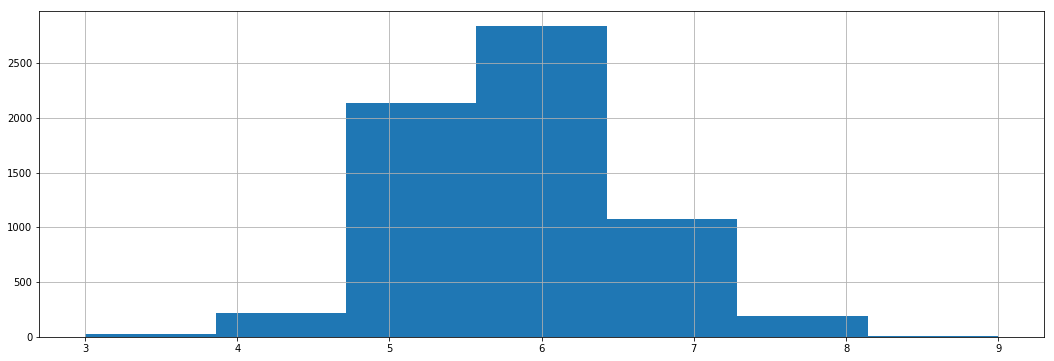

time: 309 ms


In [6]:
print( np.sort( df.quality.unique() ) )
df.quality.hist( bins=len( df.quality.unique() ), figsize=( 18, 6 ) )

# Train network with TanH

In [7]:
train_x = df.drop( 'quality', axis=1 ).values
train_y = df.quality.values
print( train_x.shape, train_y.shape )

(6497, 11) (6497,)
time: 4.31 ms


In [8]:
nn_train_x = ( ( train_x - train_x.mean() ) / train_x.var() )
nn_train_y = np.array( [ train_y == i for i in np.sort( np.unique( train_y ) ) ] ).astype( int ).T
print( nn_train_x.shape, nn_train_y.shape )

(6497, 11) (6497, 7)
time: 5.5 ms


In [9]:
m = keras.models.Sequential()
m.add( keras.layers.Dense( 128, input_dim=nn_train_x.shape[ 1 ], init='glorot_normal', activation='tanh' ) )
m.add( keras.layers.Dense( 128, init='glorot_normal', activation='tanh' ) )
m.add( keras.layers.Dense( 128, init='glorot_normal', activation='tanh' ) )
m.add( keras.layers.Dense( 128, init='glorot_normal', activation='tanh' ) )
m.add( keras.layers.Dense( 128, init='glorot_normal', activation='tanh' ) )
m.add( keras.layers.Dense( 128, init='glorot_normal', activation='tanh' ) )
m.add( keras.layers.Dense( nn_train_y.shape[ 1 ], init='glorot_normal', activation='softmax' ) )
m.compile( loss='categorical_crossentropy', optimizer='adam' )

myhist = MyHistory( m )
h = m.fit( nn_train_x, nn_train_y, batch_size=1024, nb_epoch=5000, verbose=0, callbacks=[ myhist ] )
print( 'train loss: %r' % m.evaluate( nn_train_x, nn_train_y, verbose=0 ) )
# print 'test loss:  %r' % m.evaluate( nn_test_x, nn_test_y, verbose=0 )

train loss: 0.084571105571243241
time: 2h 1min 49s


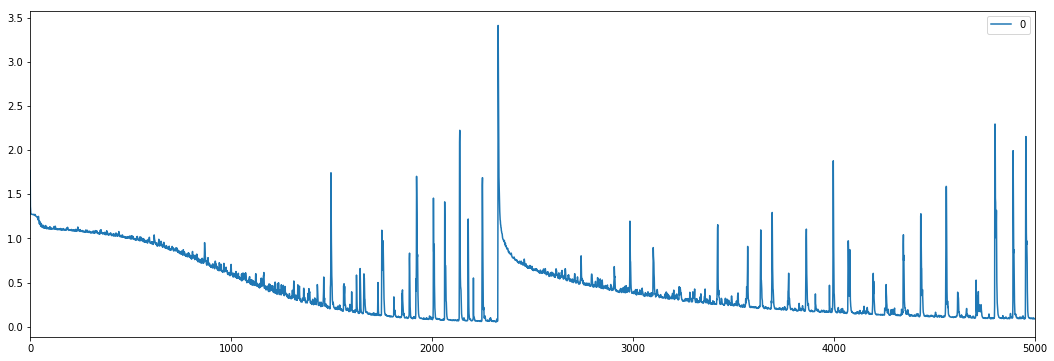

time: 262 ms


In [10]:
pd.DataFrame( h.history[ 'loss' ] ).plot.line( figsize=( 18, 6 ) )

In [11]:
print( sklearn.metrics.confusion_matrix( train_y, np.argmax( m.predict( nn_train_x ), axis=1 ) ) )

[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  27    0    0    3    0    0    0    0    0    0]
 [   0  200    9    7    0    0    0    0    0    0]
 [   0    3 2100   30    5    0    0    0    0    0]
 [   0    1   35 2795    5    0    0    0    0    0]
 [   0    0    8    9 1062    0    0    0    0    0]
 [   0    0    0    1    1  191    0    0    0    0]
 [   0    0    0    0    0    0    5    0    0    0]]
time: 658 ms


# Train network with noisy TanH

In [14]:
from keras import backend as K
def ntanh( x, alpha=1.05, c=.5 ):
    threshold = 1
    noise = K.random_normal( K.shape( x ), seed=1 )
    signs = K.sign( x )
    delta = K.abs( x ) - threshold
    scale = c * ( K.sigmoid( delta ** 2 ) - .5 ) ** 2
    # half noise
    if alpha > 1:
        scale *= -1
    noise = K.abs( noise )
    eps = scale * noise + alpha * delta
    z = x - signs * eps
    import tensorflow as tf
    res = tf.where( K.abs( x ) >= threshold, z, x )
    return res

time: 13.6 ms


In [15]:
m2 = keras.models.Sequential()
m2.add( keras.layers.Dense( 128, input_dim=nn_train_x.shape[ 1 ], init='glorot_normal', activation=ntanh ) )
m2.add( keras.layers.Dense( 128, init='glorot_normal', activation=ntanh ) )
m2.add( keras.layers.Dense( 128, init='glorot_normal', activation=ntanh ) )
m2.add( keras.layers.Dense( 128, init='glorot_normal', activation=ntanh ) )
m2.add( keras.layers.Dense( 128, init='glorot_normal', activation=ntanh ) )
m2.add( keras.layers.Dense( 128, init='glorot_normal', activation='tanh' ) )
m2.add( keras.layers.Dense( nn_train_y.shape[ 1 ], init='glorot_normal', activation='softmax' ) )
m2.compile( loss='categorical_crossentropy', optimizer='adam' )

myhist2 = MyHistory( m2 )
h2 = m2.fit( nn_train_x, nn_train_y, batch_size=1024, nb_epoch=5000, verbose=0, callbacks=[ myhist2 ] )
print( 'train loss: %r' % m2.evaluate( nn_train_x, nn_train_y, verbose=0 ) )
# print 'test loss:  %r' % m2.evaluate( nn_test_x, nn_test_y, verbose=0 )

train loss: 0.054676399523945922
time: 8h 3min 54s


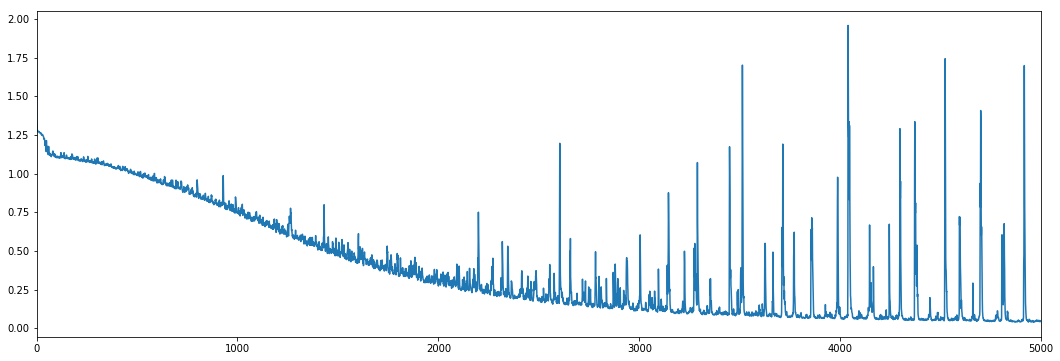

time: 430 ms


In [16]:
pd.DataFrame( h2.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ) )

In [17]:
print( sklearn.metrics.confusion_matrix( train_y, np.argmax( m2.predict( nn_train_x ), axis=1 ) ) )

[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  29    0    1    0    0    0    0    0    0    0]
 [   0  210    4    2    0    0    0    0    0    0]
 [   0    0 2121   13    4    0    0    0    0    0]
 [   0    2   20 2804   10    0    0    0    0    0]
 [   0    1    1   12 1064    1    0    0    0    0]
 [   0    0    0    0    4  189    0    0    0    0]
 [   0    0    0    0    0    0    5    0    0    0]]
time: 1.5 s


# Compare training loss and activation between the two networks

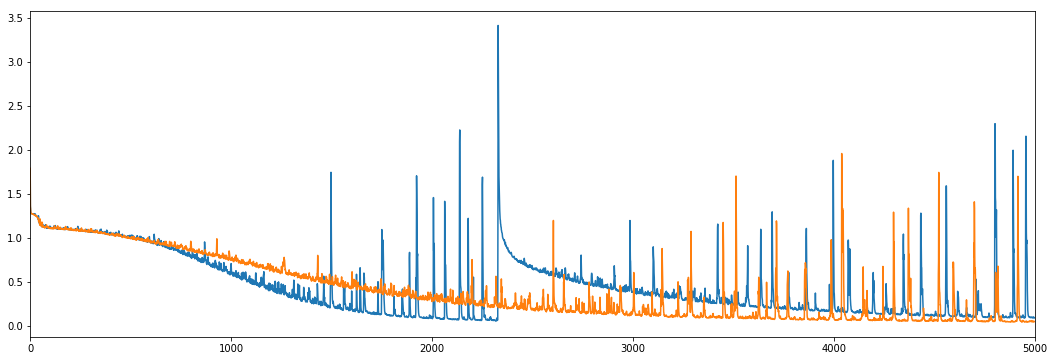

time: 314 ms


In [18]:
ax = pd.DataFrame( h.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ) )
pd.DataFrame( h2.history[ 'loss' ] ).plot.line( legend=False, figsize=( 18, 6 ), ax=ax )

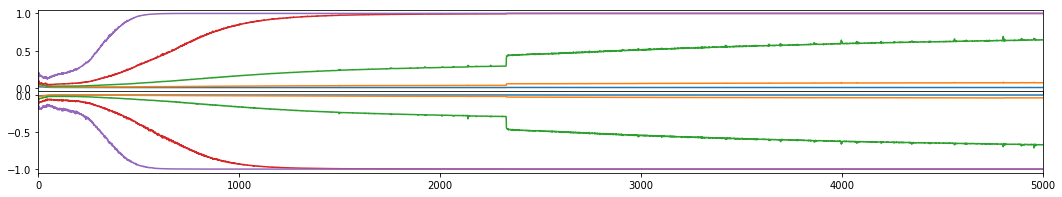

time: 1.26 s


In [19]:
fg, ax = pt.subplots( 2, sharex=True )
pd.DataFrame( myhist.a75 ).plot( ax=ax[ 0 ], figsize=( 18, 3 ), legend=False )
pd.DataFrame( myhist.a25 ).plot( ax=ax[ 1 ], legend=False )
fg.subplots_adjust( hspace=0 )

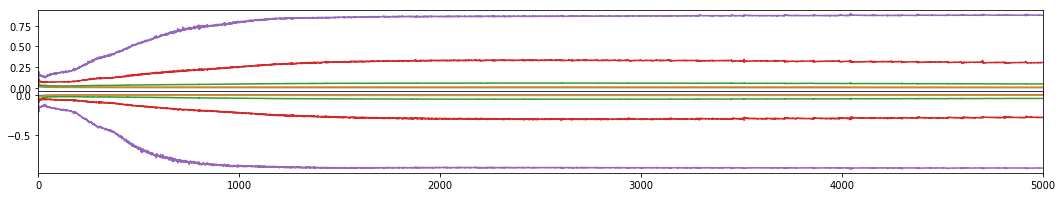

time: 562 ms


In [20]:
fg, ax = pt.subplots( 2, sharex=True )
pd.DataFrame( myhist2.a75 ).plot( ax=ax[ 0 ], figsize=( 18, 3 ), legend=False )
pd.DataFrame( myhist2.a25 ).plot( ax=ax[ 1 ], legend=False )
fg.subplots_adjust( hspace=0 )

In [21]:
print( sklearn.metrics.confusion_matrix( train_y, np.argmax( m.predict( nn_train_x ), axis=1 ) ) )

[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  27    0    0    3    0    0    0    0    0    0]
 [   0  200    9    7    0    0    0    0    0    0]
 [   0    3 2100   30    5    0    0    0    0    0]
 [   0    1   35 2795    5    0    0    0    0    0]
 [   0    0    8    9 1062    0    0    0    0    0]
 [   0    0    0    1    1  191    0    0    0    0]
 [   0    0    0    0    0    0    5    0    0    0]]
time: 274 ms


In [22]:
print( sklearn.metrics.confusion_matrix( train_y, np.argmax( m2.predict( nn_train_x ), axis=1 ) ) )

[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [  30    0    0    0    0    0    0    0    0    0]
 [   0  209    3    4    0    0    0    0    0    0]
 [   0    1 2125   10    2    0    0    0    0    0]
 [   0    2   19 2805    9    1    0    0    0    0]
 [   0    0    1   10 1066    2    0    0    0    0]
 [   0    0    1    0    1  191    0    0    0    0]
 [   0    0    0    0    0    0    5    0    0    0]]
time: 545 ms
